# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Import

In [284]:
class Params:
    MAX_LEN = 12
    vocab = " abcdefghijklmnopqrstuvwxyz" # 1-indexed
    char_to_index = {char: i for i, char in enumerate(vocab)}
    index_to_char = {i: char for i, char in enumerate(vocab)}

    @staticmethod
    def encode_string(s: str):
        return [Params.char_to_index[char] for char in s]

    @staticmethod
    def decode_string(encoded: list[int]):
        return ''.join([Params.index_to_char[i] for i in encoded if i != 0])

In [285]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torch.functional import F
from torchvision import transforms, datasets
from torchvision import models


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skimage.morphology import skeletonize
from itertools import product

import pandas as pd
import numpy as np
import os
from PIL import Image
import copy
import cv2
import time

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data

In [286]:
with open('iam_words/words.txt', 'r') as f:
    words = f.readlines()
words = [word.strip() for word in words]
words = words[18:-1]
words = [w for w in words if ' err ' not in w]
words = [[w.split(' ')[0], w.split(' ')[-1]] for w in words]
words = [
    [f'iam_words/words/{w.split('-')[0]}/{w.split('-')[0]}-{w.split('-')[1]}/{w}.png', y] for w, y in words]
df = pd.DataFrame(words, columns=['filename', 'word'])
df = df[df['filename'].apply(os.path.exists)]
# Filter out rows where the file cannot be opened
# valid_rows = []
# for _, row in df.iterrows():
#     try:
#         with Image.open(row['filename']) as img:
#             img.verify()  # Verify that the file is a valid image
#         valid_rows.append(row)
#     except Exception as e:
#         print(f"Skipping file {row['filename']} due to error: {e}")

# df = pd.DataFrame(valid_rows, columns=df.columns)
df = df[df['word'].apply(lambda x: all(char in Params.vocab[1:] for char in x) and len(x) <= Params.MAX_LEN)]
df

,filename,word
2,iam_words/words/a01/a01-000u/a01-000u-00-02.png,to
3,iam_words/words/a01/a01-000u/a01-000u-00-03.png,stop
6,iam_words/words/a01/a01-000u/a01-000u-00-06.png,from
7,iam_words/words/a01/a01-000u/a01-000u-01-00.png,nominating
8,iam_words/words/a01/a01-000u/a01-000u-01-01.png,any
...,...,...
38300,iam_words/words/e07/e07-072/e07-072-08-07.png,be
38301,iam_words/words/e07/e07-072/e07-072-09-00.png,obtained
38302,iam_words/words/e07/e07-072/e07-072-09-01.png,at
38303,iam_words/words/e07/e07-072/e07-072-09-02.png,a


In [287]:
# for i, (im, label) in df.iterrows():
    
#     img = Image.open(im)
#     if not os.path.exists(f'splited_words/{label}'):
#         os.makedirs(f'splited_words/{label}')
#     img.save(f'splited_words/{label}/{i}.png')

In [288]:
# class HandWritingDataset(datasets.ImageFolder):
#     def __init__(self, root, transform=None, label_transofrm=None):
#         super(HandWritingDataset, self).__init__(root, transform=transform)
#         self.label

# Dataset

In [289]:
class HandWritingDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augument: bool = False):
        super().__init__()
        self.df = df
        self.augument = augument
        self.compose = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(15, expand=True, fill=(255,)),
            transforms.RandomAffine(0, translate=(0.1, 0.1), fill=(255,)),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=(255,)),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx) -> tuple[tensor, tensor]:
        row = self.df.iloc[idx]
        im = Image.open(row['filename']).convert('L')

        if self.augument:
            im = self.compose(im)

        im = cv2.bitwise_not(np.array(im, dtype=np.uint8))
        im = cv2.resize(im, (512, 32), interpolation=cv2.INTER_CUBIC)
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

        im = tensor(np.array(im, dtype=np.float32), dtype=torch.float32).to(device).permute(2, 0, 1) / 255.0
        im = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(im)
        
        label = tensor(Params.encode_string(row['word'])).to(device)
        if len(label) < Params.MAX_LEN:
            label = torch.cat([label, tensor([0] * (Params.MAX_LEN - len(label))).to(device)])

        return im, label

# Loader

In [290]:
def getLoaders(df: pd.DataFrame, size: float = 1.0, batch_size: int = 4, not_train_size: float = 0.2) -> tuple[DataLoader, DataLoader, DataLoader]:
    tmpdf = df.sample(int(len(df) * size))

    train_df, test_df = train_test_split(tmpdf, test_size=not_train_size)
    test_df, val_df = train_test_split(test_df, test_size=0.5)
    
    train_dataset = HandWritingDataset(train_df, augument=True)
    test_dataset = HandWritingDataset(test_df)
    val_dataset = HandWritingDataset(val_df)

    # label_counts = train_df['word'].value_counts()
    # label_to_weight = 1 / label_counts * train_df.shape[0]
    # weights = train_df['word'].map(label_to_weight).to_numpy()

    # sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader, val_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6784315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.57647073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.592157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5450982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8431374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5529413].
Clipping input data to the valid 

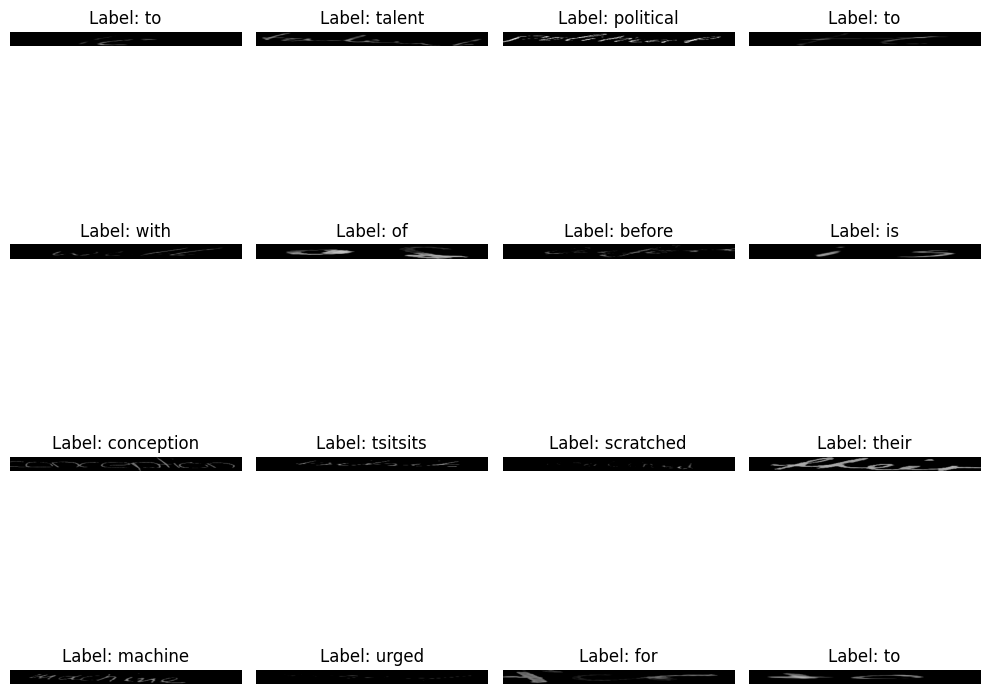

In [291]:
train_loader, test_loader, val_loader = getLoaders(df, size=0.1, batch_size=16)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (x, y) in enumerate(train_loader):
    if i >= 1:  # Process only the first batch
        break
    for j in range(min(16, x.size(0))):  # Ensure we don't exceed the batch size
        ax = axes[j // 4, j % 4]
        ax.imshow(x[j].squeeze().cpu().numpy().transpose(1, 2, 0), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Label: {Params.decode_string(y[j].cpu().numpy())}")
plt.tight_layout()
plt.show()

# Model

In [292]:
# class ConvLayer(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int, dropout: float = 0.2, maxpool: bool = True):
#         super(ConvLayer, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) if maxpool else None

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         if self.maxpool:
#             x = self.maxpool(x)
#         return x
    

class HandWritingModel(nn.Module):
    def __init__(self):
        super(HandWritingModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        # self.norm5 = nn.LayerNorm(256)

        self.dense = nn.Linear(256, 128)
        # self.norm6 = nn.LayerNorm(128)
        self.output = nn.Linear(128, len(Params.vocab))
        self.softmax = nn.LogSoftmax(dim=2)

        # self._init_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop4(x)
        x = self.pool4(x)

        x = x.permute(0, 3, 2, 1)
        x = x.flatten(2)
        x = self.lstm(x)
        x = x[0]
        # x = self.norm5(x)

        x = self.dense(x)
        # x = self.norm6(x)
        x = self.output(x)
        x = self.softmax(x)
        x = x.permute(1, 0, 2)
        return x
        
    
    # def _init_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    #             nn.init.xavier_uniform_(m.weight)
    #             if m.bias is not None:
    #                 nn.init.zeros_(m.bias)
    #         elif isinstance(m, nn.LSTM):
    #             for name, param in m.named_parameters():
    #                 if 'weight' in name:
    #                     nn.init.xavier_uniform_(param)
    #                 elif 'bias' in name:
    #                     nn.init.zeros_(param)
    #                     # Initialize forget gate bias to 1
    #                     if 'bias_ih' in name:
    #                         n = param.size(0)
    #                         param.data[n // 4:n // 2].fill_(1.0)

# Training

In [293]:
def train_model(
    model: nn.Module, 
    criterion: nn.CTCLoss, 
    optimizer: optim.Optimizer, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    epochs: int = 10
) -> None:
    print('|         ' * 10, end='|\n')
    model.train()
    best_model = model.state_dict()
    best_loss = float('inf')
    for epoch in range(epochs):
        train_losses = 0
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(x)  # Shape: (T, batch_size, num_classes)

            batch_size = x.size(0)
            input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
            target_lengths = torch.tensor([len(seq[seq != 0]) for seq in y], dtype=torch.long).to(device)

            loss = criterion(y_pred, y, input_lengths, target_lengths)

            train_losses += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if i % (len(train_loader) // 100 + 1) == 0:
                print('-', end='')
            
        with torch.no_grad():
            val_lossese = 0
            for i, _ in val_loader:
                y_pred = model(x)

                batch_size = x.size(0)
                input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
                target_lengths = torch.tensor([len(seq[seq != 0]) for seq in y], dtype=torch.long).to(device)

                loss = criterion(y_pred, y, input_lengths, target_lengths)
                val_lossese += loss.item()
        
        if val_lossese < best_loss:
            best_loss = val_lossese
            best_model = model.state_dict()
            # print(f"Best model saved with loss: {best_loss/len(val_loader):.3f}")

        print(f" Epoch {epoch+1}/{epochs}, Loss: {train_losses/len(train_loader):.3f}     Val Loss: {val_lossese/len(val_loader):.3f} ")
    model.load_state_dict(best_model)

In [294]:
def test_model(model: nn.Module, criterion: nn.CTCLoss, test_loader: DataLoader) -> float:
    model.eval()
    test_losses = 0
    for x, y in test_loader:
        y_pred = model(x)

        batch_size = x.size(0)
        input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
        target_lengths = torch.tensor([len(seq[seq != 0]) for seq in y], dtype=torch.long).to(device)

        loss = criterion(y_pred, y, input_lengths, target_lengths)

        test_losses += loss.sum().item()
        
    return test_losses / len(test_loader) / test_loader.batch_size

In [295]:
def predict(model: nn.Module, sample_df) -> list[tuple[str, str]]:
    model.eval()
    predictions = []
    test_loader = DataLoader(HandWritingDataset(sample_df), batch_size=1, shuffle=False)
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=2).squeeze(1).cpu().numpy()
            y = y.squeeze(0).cpu().numpy()
            predictions.append((Params.decode_string(y_pred), Params.decode_string(y)))
    return predictions

# Example usage

In [296]:
class TLModel(nn.Module):
    def __init__(self,):
        super(TLModel, self).__init__()
        self.mnv2 = models.mobilenet_v2(pretrained=True).features[:-1]
        for param in self.mnv2.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=320, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True, dropout=0.5)
        self.dense = nn.Linear(512, 27)

    def forward(self, x):
        x = self.mnv2(x)
        x = x.permute(0, 3, 2, 1)
        x = x.flatten(2)
        # print(x.shape)
        x, _ = self.lstm(x)
        x = self.dense(x)
        x = x.permute(1, 0, 2)
        x = F.log_softmax(x, dim=2)
        # print(x.shape)
        return x

In [297]:
criterion = nn.CTCLoss(blank=0).to(device)
# model = HandWritingModel().to(device)
model = TLModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_loader, test_loader, val_loader = getLoaders(df, size=1.0, batch_size=32, not_train_size=0.2)

/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [298]:
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

|         |         |         |         |         |         |         |         |         |         |
---------------------------------------------------------------------------------------- Epoch 1/10, Loss: 3.624     Val Loss: 2.634 
---------------------------------------------------------------------------------------- Epoch 2/10, Loss: 2.756     Val Loss: 2.074 
---------------------------------------------------------------------------------------- Epoch 3/10, Loss: 2.599     Val Loss: 2.477 
---------------------------------------------------------------------------------------- Epoch 4/10, Loss: 2.518     Val Loss: 2.277 
---------------------------------------------------------------------------------------- Epoch 5/10, Loss: 2.454     Val Loss: 2.941 
---------------------------------------------------------------------------------------- Epoch 6/10, Loss: 2.411     Val Loss: 2.480 
---------------------------------------------------------------------------------------- Epoch

In [305]:
train_loader, test_loader, val_loader = getLoaders(
    df, size=1.0, batch_size=32, not_train_size=0.2)

for param in model.mnv2.parameters():
    param.requires_grad = True

train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)

|         |         |         |         |         |         |         |         |         |         |
---------------------------------------------------------------------------------------- Epoch 1/5, Loss: 0.661     Val Loss: 0.441 
---------------------------------------------------------------------------------------- Epoch 2/5, Loss: 0.607     Val Loss: 1.481 
---------------------------------------------------------------------------------------- Epoch 3/5, Loss: 0.565     Val Loss: 0.355 
---------------------------------------------------------------------------------------- Epoch 4/5, Loss: 0.537     Val Loss: 0.372 
---------------------------------------------------------------------------------------- Epoch 5/5, Loss: 0.519     Val Loss: 0.999 


In [306]:
test_loss = test_model(model, criterion, test_loader)
print(f"Test Loss: {test_loss:.3f}")

predictions = predict(model, df.sample(50))
for i in predictions:
    print(i)

Test Loss: 0.023
('laid', 'laid')
('sivl', 'rival')
('tis', 'the')
('mast', 'most')
('abooove', 'above')
('it', 'it')
('frroom', 'from')
('figgntiinng', 'fighting')
('are', 'are')
('by', 'by')
('liiiccch', 'which')
('desiiggn', 'design')
('may', 'may')
('dosiiiatee', 'obstinate')
('hay', 'by')
('the', 'the')
('uiselesssly', 'uselessly')
('cessefaal', 'useful')
('termms', 'terms')
('to', 'to')
('resst', 'rest')
('haas', 'has')
('aaiid', 'said')
('iin', 'in')
('pojiirt', 'project')
('figghteerr', 'fighter')
('apparieencees', 'experiences')
('iin', 'in')
('miigrrate', 'migrate')
('fiveely', 'tively')
('by', 'by')
('rome', 'come')
('in', 'an')
('hn', 'we')
('nais', 'new')
('farccees', 'forces')
('hhiir', 'their')
('paaan', 'plan')
('almaast', 'almost')
('the', 'the')
('thiiir', 'their')
('if', 'if')
('pafatty', 'safety')
('to', 'to')
('are', 'are')
('for', 'for')
('theese', 'these')
('mmorriity', 'majority')
('to', 'to')
('sppiiiif', 'spite')


In [301]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model.state_dict(), f"handwriting_model{timestamp}.pth")


# Tuning

In [302]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True).to(device)

tested_parameters = list(product([16, 32, 64, 128], [64, 128, 256], [1, 2]))

train_loader, test_loader, val_loader = getLoaders(df, size=0.03, batch_size=4, not_train_size=0.2)

results = pd.DataFrame({
    'params': tested_parameters,
    'train_loss': 0.0,
    'test_loss': 0.0
})

for i in range(len(results)):
    row = results.iloc[i]
    print(f'c: {row["params"][0]}, h: {row["params"][1]}, n: {row["params"][2]}')
    model = HandWritingModel(row['params'][0], row['params'][1], row['params'][2]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs=1)
    results.loc[i, 'train_loss'] = test_model(model, criterion, train_loader)
    results.loc[i, 'test_loss'] = test_model(model, criterion, test_loader)

print(results)

c: 16, h: 64, n: 1


TypeError: HandWritingModel.__init__() takes 1 positional argument but 4 were given

<Axes: xlabel='params'>

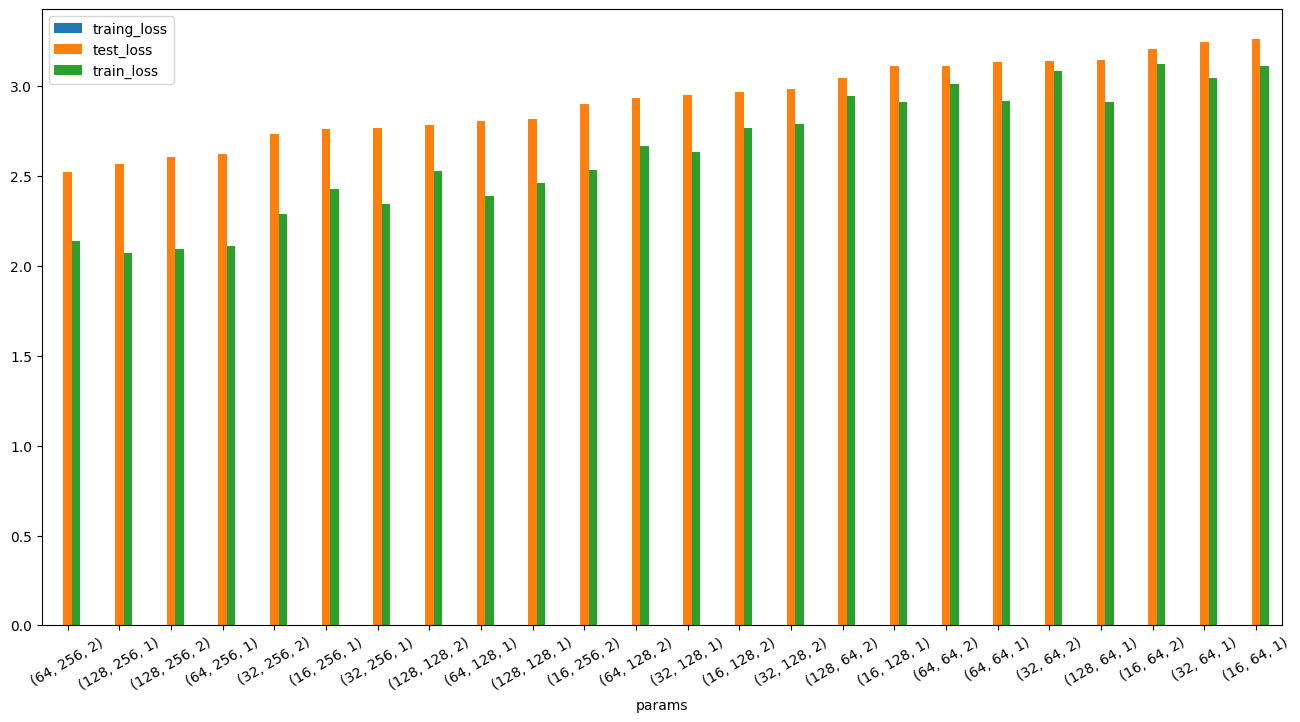

In [ ]:
results = results.sort_values(by='test_loss', ascending=True)

results.set_index('params').plot(kind='bar', figsize=(16, 8), rot=30)
